# Introduction

This movie recommendation system will suggest items based on user preference. It is trained on the [MovieLens dataset](https://grouplens.org/datasets/movielens/) which consists of movies ratings (on a scale of 1 to 5).

## Outline
  1. Exploratory Data Analysis
  2. Preliminaries
  3. Training Model

## Setup
We need to import necessary packages
- For working with data: numpy and pandas
- For visualization: matplotlib.pyplot and seaborn
- For building ML model: tensorflow
- For adding personalized data: google.colab, gspread
- For working with time: datetime and time

In [ ]:
import numpy as np
import pandas as pd
import collections
from matplotlib import pyplot as plt
import seaborn as sns
import datetime
import time
import tensorflow as tf

pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.3f}'.format

!pip install --upgrade -q gspread
from google.colab import auth
import gspread
from oauth2client.client import GoogleCredentials

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.2/55.2 kB 420.7 kB/s eta 0:00:00


In [ ]:
!pip show tensorflow

Name: tensorflow
Version: 2.15.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine-rl, tf_keras


## Load the MovieLens data

In [ ]:
!wget https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
!unzip ./ml-latest-small.zip

# Load ratings and movies data set.
ratings = pd.read_csv('./ml-latest-small/ratings.csv')
movies = pd.read_csv('./ml-latest-small/movies.csv')
ratings.head()

--2024-04-20 01:01:04--  https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K  4.49MB/s    in 0.2s    

2024-04-20 01:01:05 (4.49 MB/s) - ‘ml-latest-small.zip’ saved [978202/978202]

Archive:  ./ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


,userId,movieId,rating,timestamp
0,1,1,4.000,964982703
1,1,3,4.000,964981247
2,1,6,4.000,964982224
3,1,47,5.000,964983815
4,1,50,5.000,964982931


In [ ]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
import re
[m for m in movies["title"] if re.search("[0-9]{4}", m.strip()[-5:-1]) is None]

['Babylon 5',
 'Ready Player One',
 'Hyena Road',
 'The Adventures of Sherlock Holmes and Doctor Watson',
 'Nocturnal Animals',
 'Paterson',
 'Moonlight',
 'The OA',
 'Cosmos',
 'Maria Bamford: Old Baby',
 'Generation Iron 2',
 'Black Mirror']

# I. Exploratory Data Analysis

In [ ]:
def flatten_cols(df):
  df.columns = [' '.join(col).strip() for col in df.columns.values]
  return df
pd.DataFrame.flatten_cols = flatten_cols

<Axes: xlabel='rating mean', ylabel='Count'>

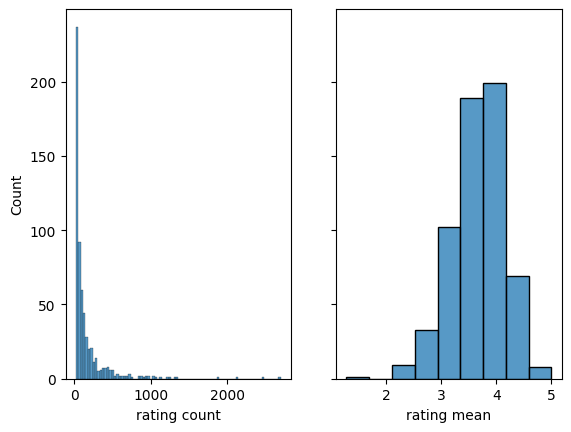

In [ ]:
fig, axs = plt.subplots(ncols=2, sharey=True)
user_ratings = ratings.groupby("userId", as_index=False).agg({"rating": ['count', 'mean']}).flatten_cols()
sns.histplot(user_ratings, x="rating count", ax=axs[0])
sns.histplot(user_ratings, x="rating mean", bins=9, ax=axs[1])

In [ ]:
movie_ratings = ratings.groupby("movieId", as_index=False).agg({"rating": ['count', 'mean']}).flatten_cols().merge(movies, on='movieId')
movie_ratings[["title", "rating count", "rating mean"]].sort_values("rating count", ascending=False).head(10)

,title,rating count,rating mean
314,Forrest Gump (1994),329,4.164
277,"Shawshank Redemption, The (1994)",317,4.429
257,Pulp Fiction (1994),307,4.197
510,"Silence of the Lambs, The (1991)",279,4.161
1938,"Matrix, The (1999)",278,4.192
224,Star Wars: Episode IV - A New Hope (1977),251,4.231
418,Jurassic Park (1993),238,3.750
97,Braveheart (1995),237,4.032
507,Terminator 2: Judgment Day (1991),224,3.971
461,Schindler's List (1993),220,4.225


In [ ]:
movie_ratings[["title", "rating count", "rating mean"]].sort_values('rating mean', ascending=False).head(10)

,title,rating count,rating mean
7638,Paper Birds (Pájaros de papel) (2010),1,5.000
8089,"Act of Killing, The (2012)",1,5.000
9065,Jump In! (2007),1,5.000
9076,Human (2015),1,5.000
9078,L.A. Slasher (2015),1,5.000
4245,Lady Jane (1986),1,5.000
8136,Bill Hicks: Revelations (1993),1,5.000
8130,Justice League: Doom (2012),1,5.000
4240,Open Hearts (Elsker dig for evigt) (2002),1,5.000
9104,Formula of Love (1984),1,5.000


In [ ]:
movie_ratings[["title", "rating count", "rating mean"]].sort_values('rating mean').head(10)

,title,rating count,rating mean
5541,Lionheart (1990),1,0.500
2685,Gypsy (1962),1,0.500
4872,"Follow Me, Boys! (1966)",1,0.500
9099,Idaho Transfer (1973),1,0.500
7280,Case 39 (2009),1,0.500
9103,Bloodsport: The Dark Kumite (1999),1,0.500
7536,Hard Ticket to Hawaii (1987),1,0.500
8764,Superfast! (2015),1,0.500
8125,Yongary: Monster from the Deep (1967),1,0.500
9572,The Emoji Movie (2017),1,0.500


In [ ]:
tmp = movie_ratings[movie_ratings["rating count"] > 20]
tmp[["title", "rating count", "rating mean"]].sort_values('rating mean', ascending=False).head(10)

,title,rating count,rating mean
277,"Shawshank Redemption, The (1994)",317,4.429
704,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),27,4.333
680,"Philadelphia Story, The (1940)",29,4.310
413,In the Name of the Father (1993),25,4.300
905,Lawrence of Arabia (1962),45,4.300
210,Hoop Dreams (1994),29,4.293
659,"Godfather, The (1972)",192,4.289
934,Harold and Maude (1971),26,4.288
9445,Logan (2017),25,4.280
2224,Fight Club (1999),218,4.273


<Axes: xlabel='rating mean', ylabel='Count'>

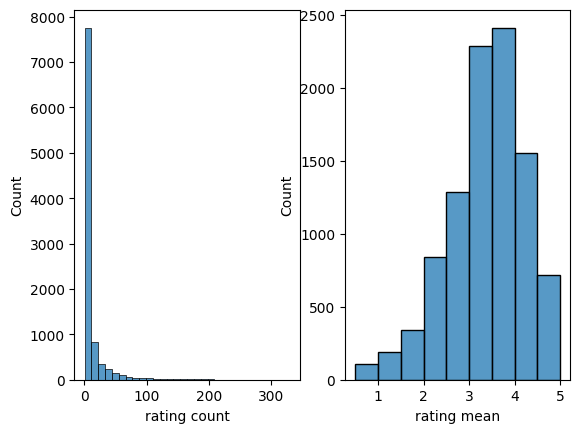

In [ ]:
fig, axs = plt.subplots(ncols=2)
sns.histplot(movie_ratings, x="rating count", bins=30, ax=axs[0])
sns.histplot(movie_ratings, x="rating mean", bins=9, ax=axs[1])

In [ ]:
global_mean = ratings["rating"].mean()
print("Global Mean Rating: {} starts".format(global_mean))

Global Mean Rating: 3.501556983616962 starts


In [ ]:
distinct_users = ratings["userId"].unique()
user_count = distinct_users.shape[0]
print("Number of users: {}".format(user_count))

Number of users: 610


In [ ]:
distinct_movies = ratings["movieId"].unique()
movie_count = distinct_movies.shape[0]
print("Number of movies: {}".format(movie_count))

Number of movies: 9724


In [ ]:
start_time = ratings["timestamp"].min()
end_time = ratings["timestamp"].max()
print(f"Start time: {datetime.datetime.fromtimestamp(start_time)}")
print(f"End time: {datetime.datetime.fromtimestamp(end_time)}")

Start time: 1996-03-29 18:36:55
End time: 2018-09-24 14:27:30


# II. Preliminaries

$$
\hat{r}_{ui} = \mu + b_u + b_i + \sum_{k=1}^K x_{i} \beta_k + \langle U_u, V_i \rangle
$$
where $x_{ui} = 1$ if movie $i$ is of genre $k$

## Remap the ID indexes
The `userId` begins with 0. The same thing happens with `movieId`, which is also non-consecutive.


In [ ]:
user_mapping = dict(zip(distinct_users, np.arange(user_count)))
ratings.loc[:, "user_id"] = ratings.loc[:, "userId"].apply(lambda x: user_mapping[x])
movie_mapping = dict(zip(distinct_movies, np.arange(movie_count)))
ratings.loc[:, "movie_id"] = ratings.loc[:, "movieId"].apply(lambda x: movie_mapping[x])
ratings.head()

,userId,movieId,rating,timestamp,user_id,movie_id
0,1,1,4.000,964982703,0,0
1,1,3,4.000,964981247,0,1
2,1,6,4.000,964982224,0,2
3,1,47,5.000,964983815,0,3
4,1,50,5.000,964982931,0,4


In [ ]:
movies.loc[:, "movie_id"] = movies.loc[:, "movieId"].apply(lambda x: -1 if movie_mapping.get(x) is None else movie_mapping[x])

## One hot encode the genre

In [ ]:
genre_list = [
    "Action", "Adventure", "Animation", "Children", "Comedy", "Crime",
    "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror", "Musical",
    "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"
]
genre_count = len(genre_list)

movies["genre"] = pd.Series([[float(g in movies.loc[i, "genres"].split('|')) for g in genre_list] for i in range(movies.shape[0])])
movies = movies.loc[movies['movie_id'] != -1].sort_values(by=['movie_id'])
movies.head()

,movieId,title,genres,movie_id,genre
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,"[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, ..."
2,3,Grumpier Old Men (1995),Comedy|Romance,1,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
5,6,Heat (1995),Action|Crime|Thriller,2,"[1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
43,47,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
46,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,4,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."


## Train / test split

In [ ]:
"""
ratings.sort_values(by="timestamp")

def split_df(df, frac=0.1):
  n = int(df.shape[0])
  n = n - 1 - int(n * frac)
  train = df.loc[:n]
  test = df.loc[n:]
  return train, test
"""
def split_df(df, frac=0.1):
  test = df.sample(frac=frac, replace=False)
  train = df[~df.index.isin(test.index)]
  return train, test

## Adding my own rating to the dataset

In [ ]:
auth.authenticate_user()
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

try:
  sh = gc.open('MyRating')
except(gspread.SpreadsheetNotFound):
  sh = gc.create('MyRating')

worksheet = sh.sheet1
titles = movies['title'].values
cell_list = worksheet.range(1, 1, len(titles), 1)
for cell, title in zip(cell_list, titles):
  cell.value = title
worksheet.update_cells(cell_list)
print("Link to the spreadsheet: "
      "https://docs.google.com/spreadsheets/d/{}/edit".format(sh.id))

Link to the spreadsheet: https://docs.google.com/spreadsheets/d/17kdciuKi81dlzMOxN8kX8q3MOe2Zx_agdeLCj8ydPM0/edit


Go to the above link, input your rating and run the subsequent cell to load the rating into the original dataset

In [ ]:
new_ratings = pd.DataFrame.from_records(worksheet.get_all_values()).reset_index()
new_ratings = new_ratings[new_ratings[1] != '']
new_ratings = pd.DataFrame({
    'userId': -1,
    'movieId': -1,
    'rating': list(map(float, new_ratings[1])),
    'timestamp': 0,
    'user_id': user_count,
    'movie_id': new_ratings['index']
})
ratings = pd.concat([ratings, new_ratings], ignore_index=True)
user_count += 1

In [ ]:
ratings[ratings['user_id'] == user_count]

,userId,movieId,rating,timestamp,user_id,movie_id


## Sparse Representation of the Rating Matrix
The rating matrix could be very large and, in general, most of the entries are unobserved, since a given user will typically rate a small subset of movies. For effcient representation, we will use a [tf.SparseTensor](https://www.tensorflow.org/api_docs/python/tf/SparseTensor).

In [ ]:
def to_sparse_tensor(df):
  return tf.SparseTensor(
      indices=df[['user_id', 'movie_id']].values,
      values=df['rating'].values,
      dense_shape=[user_count, movie_count]
  )

## Calculating the loss
Regularization of the model parameters: $$
R = \lambda_u \sum_{u=1}^{N} b_u^2 + \lambda_i \sum_{i=1}^{M} b_i^2 + \lambda_k \sum_{k=1}^{K} \beta_k^2 + \lambda_e(\frac{1}{N} \sum_{u=1}^{N} ||U_u||^2 + \frac{1}{M} \sum_{i=1}^{M} ||V_i||^2)
$$
A global prior that pushes the joint effect of any user-item pair towards zero, called the *gravity* term
$$
G = \lambda_g \frac{1}{NM} \sum_{u=1}^{N} \sum_{i=1}^{M} \langle U_u, V_i \rangle^2
$$
The total loss is then given by
$$
\frac{1}{|\Omega|} \sum_{(u,i) \in \Omega} (r_{ui} - \hat{r}_{ui}) + R + G
$$

In [ ]:
genre_matrix = np.stack(movies["genre"].values, dtype="float32")
genre_matrix

array([[0., 1., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 1., 0., 0.],
       ...,
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
class Regularization:
  def __init__(self, u, i, k, e, g):
    self.u = u
    self.i = i
    self.k = k
    self.e = e
    self.g = g

def sparse_rmse(sparse_ratings, gmean, user_bias, item_bias, genre_bias, user_embeddings, item_embeddings):
  """
  Arguments:
    sparse_ratings: A SparseTensor rating matrix, of dense_shape [N, M]
    gmean: The global mean rating
    user_bias: A dense Tenser bu of shape [N,] such that bu_u is the bias for user u
    item_bias: A dense Tenser bi of shape [M,] such that bi_i is the bias for item i
    genre_bias: A dense Tenser B of shape [K,] such that B_k is the bias for genre k
    user_embeddings: A dense Tensor U of shape [N, d] such that U_u is the embedding of user u
    movie_embeddings: A dense Tensor V of shape [M, d] such that V_i is the embedding of item i
      where d is the embedding dimension
  Returns:
    A scalar Tensor representing the RMSE between the true ratings and the model's predictions.
  """
  user_index, item_index = sparse_ratings.indices[:, 0], sparse_ratings.indices[:, 1]
  # genre_score = tf.map_fn(lambda i: movies.loc[movies["movie_id"] == i, "genre"].values[0] * genre_bias, item_index)
  # tf.reduce_sum(genre_score, axis=2)[:, 0] \
  genre_score = tf.squeeze(tf.matmul(genre_matrix, [genre_bias], transpose_b=True))
  predictions = \
    gmean + tf.gather(user_bias, user_index) + tf.gather(item_bias, item_index) \
    + tf.gather(genre_score, item_index) \
    + tf.reduce_sum(
      tf.gather(user_embeddings, user_index) *
      tf.gather(item_embeddings, item_index),
      axis=1
    )
  loss = tf.losses.mean_squared_error(sparse_ratings.values, predictions)
  return loss

In [ ]:
def gravity(U, V):
  return 1. / (U.shape[0] * V.shape[0]) * tf.reduce_sum(tf.matmul(U, U, transpose_a=True) * tf.matmul(V, V, transpose_a=True))

# III. Training model

In [ ]:
def train_model(ratings, coefs, embedding_dim=3, num_epochs=100, learning_rate=1.0):
  """
  Arguments:
    ratings: a DataFrame of the ratings
    embedding_dim: the dimension of the embedding vectors
    coefs: Regularization coefficients
  """
  train, test = split_df(ratings)
  sparse_train = to_sparse_tensor(train)
  sparse_test = to_sparse_tensor(test)

  bu = tf.Variable(tf.random.normal([user_count]), stddev=0.1)
  bi = tf.Variable(tf.random.normal([movie_count]), stddev=0.1)
  bk = tf.Variable(tf.random.normal([genre_count]), stddev=0.1)
  U = tf.Variable(tf.random.normal([user_count, embedding_dim], stddev=0.1))
  V = tf.Variable(tf.random.normal([movie_count, embedding_dim], stddev=0.1))

  trainable_vars = [bu, bi, bk, U, V]
  metrics_vals = {
    'train_error': [],
    'regularization_loss': [],
    'gravity_loss': [],
    'test_error': []
  }
  epochs = []

  opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)

  for epoch in range(1, num_epochs + 1):
    with tf.GradientTape() as tape:
      train_error = sparse_rmse(sparse_train, global_mean, bu, bi, bk, U, V)
      test_error = sparse_rmse(sparse_test, global_mean, bu, bi, bk, U, V)
      regularization_loss = \
        coefs.u * tf.reduce_sum(bu * bu) + coefs.i * tf.reduce_sum(bi * bi) + coefs.k * tf.reduce_sum(bk * bk) + \
        coefs.e * (tf.reduce_sum(U * U) / user_count + tf.reduce_sum(V * V) / movie_count)
      gravity_loss = coefs.g * gravity(U, V)
      total_loss = train_error + regularization_loss + gravity_loss
      results = {
        'train_error': train_error,
        'regularization_loss': regularization_loss,
        'gravity_loss': gravity_loss,
        'test_error': test_error
      }

    gradients = tape.gradient(total_loss, trainable_vars)
    opt.apply_gradients(zip(gradients, trainable_vars))

    if (epoch % 10 == 0) or epoch == num_epochs:
      print("\r iteration %d: " % epoch + ", ".join(["%s=%f" % (k, v) for k, v in results.items()]))
      epochs.append(epoch)
      for k, v in metrics_vals.items():
        v.append(results[k])

  fig = plt.figure()
  fig.set_size_inches(10, 8)
  for k, v in metrics_vals.items():
    plt.plot(epochs, v, label=k)
  plt.xlabel('Epochs')
  plt.ylabel('Value')
  plt.legend()
  plt.show()

  return {"user_bias": bu, "movie_bias": bi, "genre_bias": bk, "user_embedding": U, "item_embedding": V}

 iteration 10: train_error=2.802318, regularization_loss=27.479080, gravity_loss=0.003442, test_error=2.773887
 iteration 20: train_error=2.370587, regularization_loss=24.186354, gravity_loss=0.003436, test_error=2.352125
 iteration 30: train_error=2.086645, regularization_loss=21.306953, gravity_loss=0.003429, test_error=2.074783
 iteration 40: train_error=1.875886, regularization_loss=18.780416, gravity_loss=0.003423, test_error=1.868134
 iteration 50: train_error=1.711501, regularization_loss=16.560156, gravity_loss=0.003417, test_error=1.706490
 iteration 60: train_error=1.579624, regularization_loss=14.607283, gravity_loss=0.003411, test_error=1.576620
 iteration 70: train_error=1.471889, regularization_loss=12.888505, gravity_loss=0.003405, test_error=1.470480
 iteration 80: train_error=1.382750, regularization_loss=11.375036, gravity_loss=0.003400, test_error=1.382688
 iteration 90: train_error=1.308297, regularization_loss=10.041842, gravity_loss=0.003394, test_error=1.309424
 

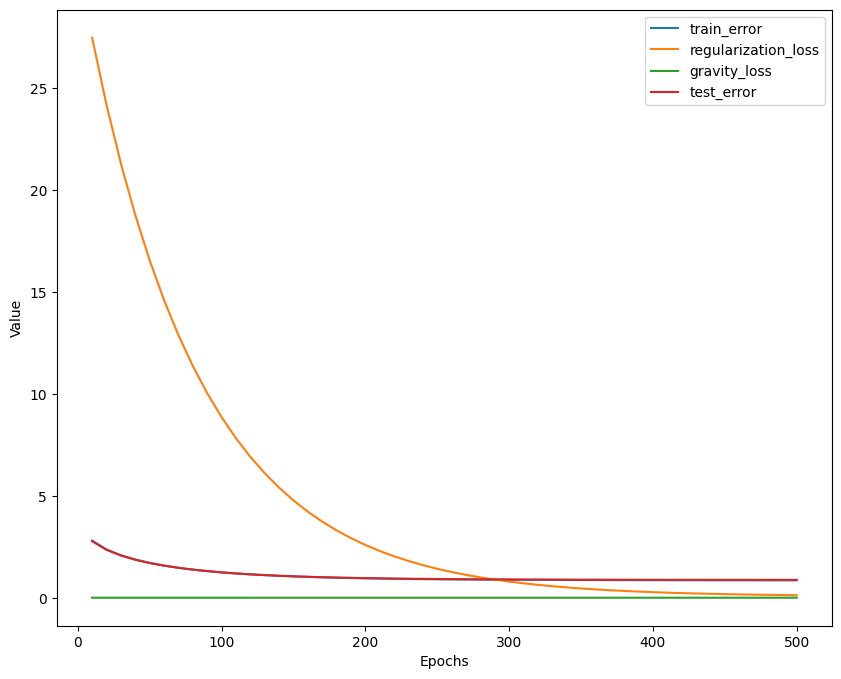

In [ ]:
embeddings = train_model(ratings, Regularization(0.003, 0.003, 0.01, 0.01, 1.0), embedding_dim=35, num_epochs=500, learning_rate=1.0)

#IV. Recommendation

In [ ]:
def predict(model, uid, mid):
  res = global_mean + model["user_bias"][uid] + model["movie_bias"][mid] + \
    np.dot(genre_matrix[mid], tf.transpose(embeddings["genre_bias"])) + \
    np.dot(embeddings["user_embedding"][uid], embeddings["item_embedding"][mid])
  return res.numpy()

In [ ]:
print([predict(embeddings, user_count - 1, i) for i in [322, 375, 478, 735, 744, 774, 778, 808]])

[3.7215235, 3.771377, 3.588273, 3.6028626, 3.5958467, 3.8034425, 3.600292, 3.436581]


In [ ]:
def recommend(model, uid, exclude_rated=True):
  df = pd.DataFrame({
      'score': [predict(model, uid, i) for i in range(movie_count)],
      'movie_id': movies['movie_id'],
      'titles': movies['title'],
      'genres': movies['genres'],
  })
  if exclude_rated:
    # remove movies that are already rated
    rated_movies = ratings[ratings.user_id == uid]["movie_id"].values
    df = df[df.movie_id.apply(lambda movie_id: movie_id not in rated_movies)]
  return df.sort_values(['score'], ascending=False)

In [ ]:
recommend(embeddings, user_count - 1).head(10)

,score,movie_id,titles,genres
6826,4.290,2365,Waltz with Bashir (Vals im Bashir) (2008),Animation|Documentary|Drama|War
5556,4.163,9094,Patlabor: The Movie (Kidô keisatsu patorebâ: T...,Action|Animation|Crime|Drama|Film-Noir|Mystery...
9633,4.135,4461,Loving Vincent (2017),Animation|Crime|Drama
277,4.108,232,"Shawshank Redemption, The (1994)",Crime|Drama
9355,4.100,7191,Batman: The Killing Joke (2016),Action|Animation|Crime|Drama
5640,4.079,3675,Joint Security Area (Gongdong gyeongbi guyeok ...,Crime|Drama|Mystery|Thriller|War
5443,4.066,6752,Night and Fog (Nuit et brouillard) (1955),Crime|Documentary|War
6176,4.064,2308,Brick (2005),Crime|Drama|Film-Noir|Mystery
4025,4.051,3185,Grave of the Fireflies (Hotaru no haka) (1988),Animation|Drama|War
1122,4.039,2086,Lost Highway (1997),Crime|Drama|Fantasy|Film-Noir|Mystery|Romance


#V. Extension

## Baseline predictor only

In [ ]:
def train_01(ratings, coefs, num_epochs=100, learning_rate=1.0):
  def rmse(sparse_ratings, gmean, user_bias, item_bias):
    user_index, item_index = sparse_ratings.indices[:, 0], sparse_ratings.indices[:, 1]
    predictions = gmean + tf.gather(user_bias, user_index) + tf.gather(item_bias, item_index)
    return tf.losses.mean_squared_error(sparse_ratings.values, predictions)
  """
  Arguments:
    ratings: a DataFrame of the ratings
    embedding_dim: the dimension of the embedding vectors
    coefs: Regularization coefficients
  """
  train, test = split_df(ratings)
  sparse_train = to_sparse_tensor(train)
  sparse_test = to_sparse_tensor(test)

  bu = tf.Variable(tf.random.normal([user_count]), stddev=0.1)
  bi = tf.Variable(tf.random.normal([movie_count]), stddev=0.1)

  trainable_vars = [bu, bi]
  metrics_vals = {
    'train_error': [],
    'regularization_loss': [],
    'test_error': []
  }
  epochs = []

  opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)

  for epoch in range(1, num_epochs + 1):
    with tf.GradientTape() as tape:
      train_error = rmse(sparse_train, global_mean, bu, bi)
      test_error = rmse(sparse_test, global_mean, bu, bi)
      regularization_loss = \
        coefs.u * tf.reduce_sum(bu * bu) + coefs.i * tf.reduce_sum(bi * bi)
      total_loss = train_error + regularization_loss
      results = {
        'train_error': train_error,
        'regularization_loss': regularization_loss,
        'test_error': test_error
      }

    gradients = tape.gradient(total_loss, trainable_vars)
    opt.apply_gradients(zip(gradients, trainable_vars))

    if (epoch % 10 == 0) or epoch == num_epochs:
      print("\r iteration %d: " % epoch + ", ".join(["%s=%f" % (k, v) for k, v in results.items()]))
      epochs.append(epoch)
      for k, v in metrics_vals.items():
        v.append(results[k])

  fig = plt.figure()
  fig.set_size_inches(10, 8)
  for k, v in metrics_vals.items():
    plt.plot(epochs, v, label=k)
  plt.xlabel('Epochs')
  plt.ylabel('Value')
  plt.legend()
  plt.show()

 iteration 10: train_error=2.589530, regularization_loss=27.422821, test_error=2.593477
 iteration 20: train_error=2.270838, regularization_loss=24.153629, test_error=2.279248
 iteration 30: train_error=2.028080, regularization_loss=21.285315, test_error=2.039720
 iteration 40: train_error=1.838045, regularization_loss=18.765549, test_error=1.852184
 iteration 50: train_error=1.686215, regularization_loss=16.549946, test_error=1.702363
 iteration 60: train_error=1.562995, regularization_loss=14.600439, test_error=1.580792
 iteration 70: train_error=1.461757, regularization_loss=12.884131, test_error=1.480926
 iteration 80: train_error=1.377759, regularization_loss=11.372468, test_error=1.398083
 iteration 90: train_error=1.307513, regularization_loss=10.040574, test_error=1.328817
 iteration 100: train_error=1.248387, regularization_loss=8.866722, test_error=1.270532
 iteration 110: train_error=1.198355, regularization_loss=7.831895, test_error=1.221231
 iteration 120: train_error=1.15

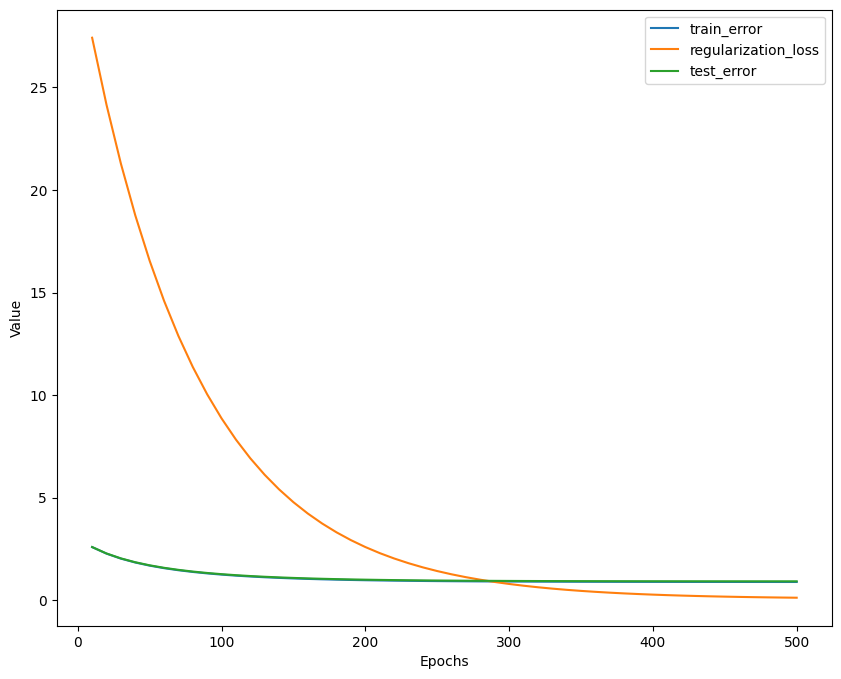

In [ ]:
train_01(ratings, Regularization(0.003, 0.003, 0, 0, 0), num_epochs=500, learning_rate=1.0)

## Baseline Predictor + Collaborative Filtering

In [ ]:
def train_02(ratings, coefs, embedding_dim=3, num_epochs=100, learning_rate=1.0):
  def rmse(sparse_ratings, gmean, user_bias, item_bias, user_embeddings, item_embeddings):
    user_index, item_index = sparse_ratings.indices[:, 0], sparse_ratings.indices[:, 1]
    predictions = gmean + tf.gather(user_bias, user_index) + tf.gather(item_bias, item_index) \
      + tf.reduce_sum(
        tf.gather(user_embeddings, user_index) *
        tf.gather(item_embeddings, item_index),
        axis=1
      )
    return tf.losses.mean_squared_error(sparse_ratings.values, predictions)
  """
  Arguments:
    ratings: a DataFrame of the ratings
    embedding_dim: the dimension of the embedding vectors
    coefs: Regularization coefficients
  """
  train, test = split_df(ratings)
  sparse_train = to_sparse_tensor(train)
  sparse_test = to_sparse_tensor(test)

  bu = tf.Variable(tf.random.normal([user_count]), stddev=0.1)
  bi = tf.Variable(tf.random.normal([movie_count]), stddev=0.1)
  U = tf.Variable(tf.random.normal([user_count, embedding_dim], stddev=0.1))
  V = tf.Variable(tf.random.normal([movie_count, embedding_dim], stddev=0.1))

  trainable_vars = [bu, bi, U, V]
  metrics_vals = {
    'train_error': [],
    'regularization_loss': [],
    'gravity_loss': [],
    'test_error': []
  }
  epochs = []

  opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)

  for epoch in range(1, num_epochs + 1):
    with tf.GradientTape() as tape:
      train_error = rmse(sparse_train, global_mean, bu, bi, U, V)
      test_error = rmse(sparse_test, global_mean, bu, bi, U, V)
      regularization_loss = \
        coefs.u * tf.reduce_sum(bu * bu) + coefs.i * tf.reduce_sum(bi * bi) + \
        coefs.e * (tf.reduce_sum(U * U) / user_count + tf.reduce_sum(V * V) / movie_count)
      gravity_loss = coefs.g * gravity(U, V)
      total_loss = train_error + regularization_loss + gravity_loss
      results = {
        'train_error': train_error,
        'regularization_loss': regularization_loss,
        'gravity_loss': gravity_loss,
        'test_error': test_error
      }

    gradients = tape.gradient(total_loss, trainable_vars)
    opt.apply_gradients(zip(gradients, trainable_vars))

    if (epoch % 10 == 0) or epoch == num_epochs:
      print("\r iteration %d: " % epoch + ", ".join(["%s=%f" % (k, v) for k, v in results.items()]))
      epochs.append(epoch)
      for k, v in metrics_vals.items():
        v.append(results[k])

  fig = plt.figure()
  fig.set_size_inches(10, 8)
  for k, v in metrics_vals.items():
    plt.plot(epochs, v, label=k)
  plt.xlabel('Epochs')
  plt.ylabel('Value')
  plt.legend()
  plt.show()

 iteration 10: train_error=2.599819, regularization_loss=27.411449, gravity_loss=0.003422, test_error=2.565674
 iteration 20: train_error=2.281507, regularization_loss=24.156263, gravity_loss=0.003394, test_error=2.253742
 iteration 30: train_error=2.043205, regularization_loss=21.299152, gravity_loss=0.003366, test_error=2.019665
 iteration 40: train_error=1.857054, regularization_loss=18.788162, gravity_loss=0.003339, test_error=1.836664
 iteration 50: train_error=1.707619, regularization_loss=16.579439, gravity_loss=0.003312, test_error=1.689751
 iteration 60: train_error=1.585437, regularization_loss=14.635379, gravity_loss=0.003285, test_error=1.569677
 iteration 70: train_error=1.484235, regularization_loss=12.923446, gravity_loss=0.003259, test_error=1.470283
 iteration 80: train_error=1.399605, regularization_loss=11.415347, gravity_loss=0.003233, test_error=1.387232
 iteration 90: train_error=1.328312, regularization_loss=10.086390, gravity_loss=0.003208, test_error=1.317342
 

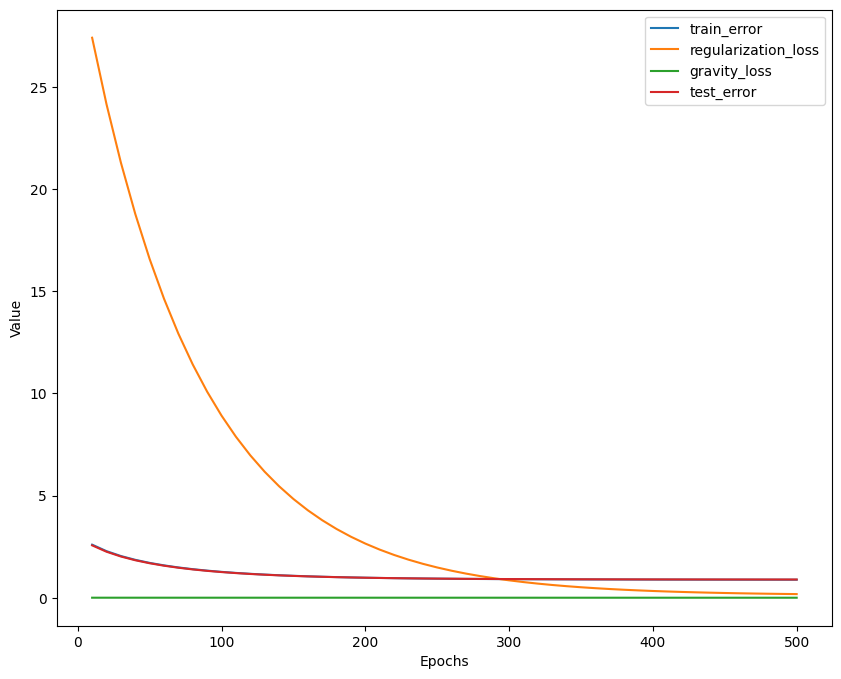

In [ ]:
train_02(ratings, Regularization(0.003, 0.003, 0, 0.1, 1), embedding_dim=35, num_epochs=500, learning_rate=1.0)